# Analysis of Parameter Estimation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tellurium as te  
import json

### Load all data relevant for analysis

In [44]:
pth_model = te.loada('LCT_model/LCT_OIE.ant')
non_pth_model = te.loada('LCT_model/LCT_OIE.ant')

data = pd.read_csv('datasets/OIE_data.csv')

fit_data_pth = pd.read_csv('Estimation/pth.csv')
with open('Estimation/pth/2023_12_14_14_50_1.json', 'r') as f:
  pth_result = json.load(f)
            
fit_data_non_pth = pd.read_csv('Estimation/non_pth.csv')
with open('Estimation/non_pth/2023_12_14_14_50_1.json', 'r') as f:
  non_pth_result = json.load(f)


In [45]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 13)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    pth_model.setValue(p, pth_result['update_parameters'][p])

pre_t = pth_result['best_parameters']['pre_t']
pth_res = pth_model.simulate(-pre_t, 50, 100, selections=species_selct)
pth_res_df = pd.DataFrame(pth_res, columns=pth_res.colnames) 

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    non_pth_model.setValue(p, non_pth_result['update_parameters'][p])

pre_t = non_pth_result['best_parameters']['pre_t']
non_pth_res = non_pth_model.simulate(-pre_t, 50, 100, selections=species_selct)
non_pth_res_df = pd.DataFrame(non_pth_res, columns=non_pth_res.colnames) 


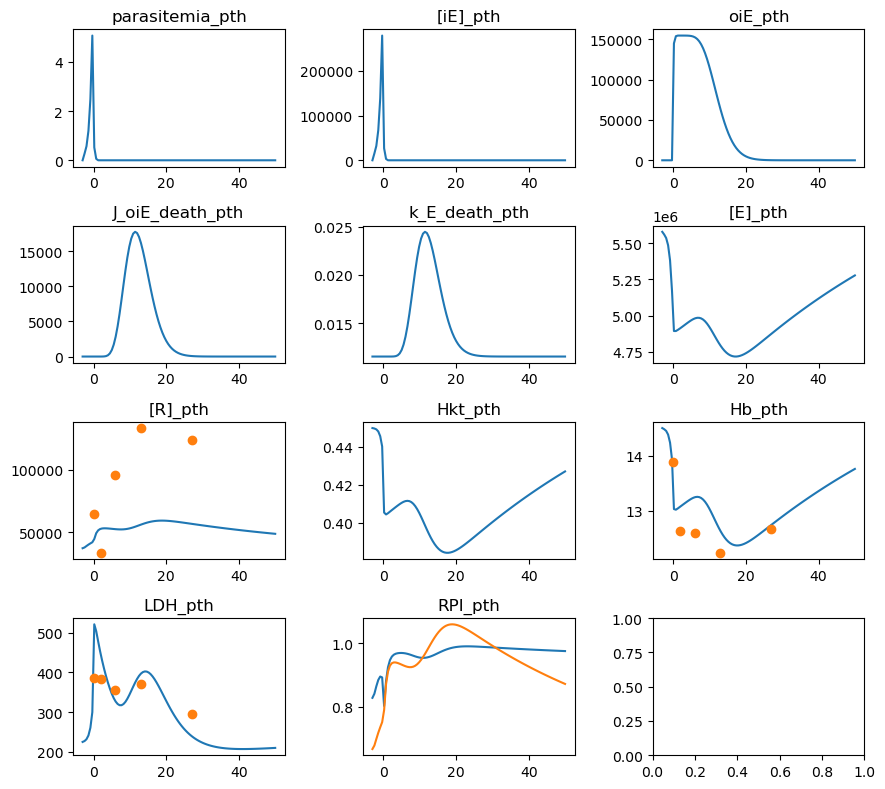

In [46]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI']

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(pth_res_df['time'], pth_res_df[obs])

    ax[row, col].set_title(obs+"_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (pth_res_df['[R]'] / (pth_res_df['[R]'] + pth_res_df['[E]']+pth_res_df['[iE]'] + pth_res_df['oiE'])) * 100 * pth_res_df['Hkt'] / 0.45
ax[3, 1].plot(pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()


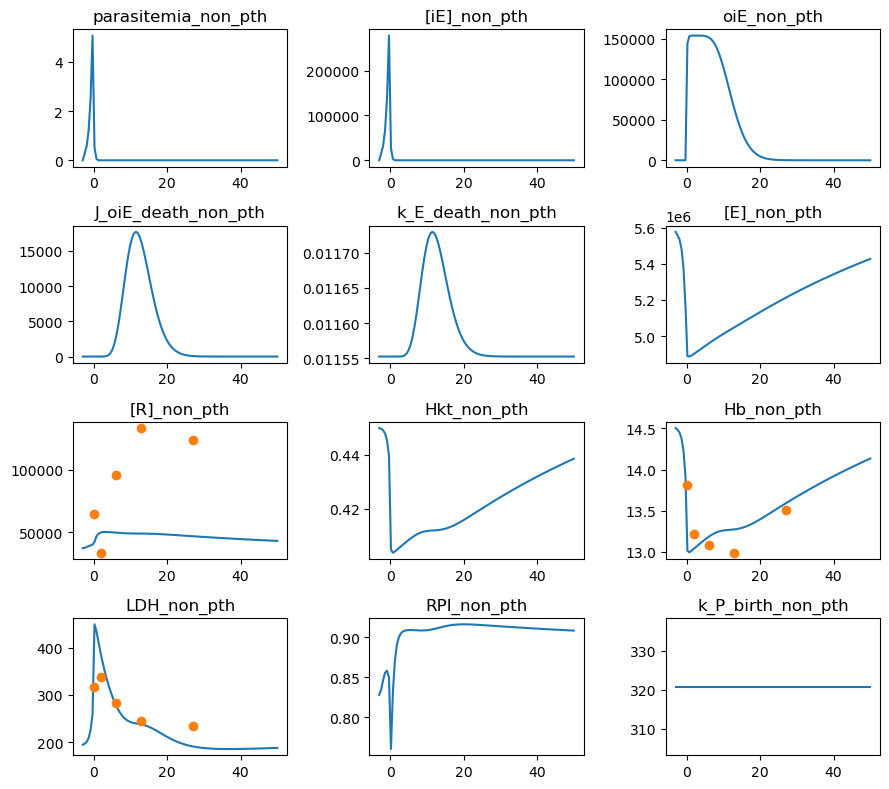

In [47]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI',"k_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs])

    ax[row, col].set_title(obs+"_non_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')

plt.tight_layout()  
plt.show()


In [48]:
tester ={    # 'Hkt_init': (0.35, 0.55, False),   
    'k_E_infect': (1e-7 , 2.5e-6, True),    #jetzt paramscan früher (1e-8 , 1e-4),

    # 's_P_d': (1e-6, 1e-1, True),     # sigmoid(1e-2, 1e2) ,      #linear #parameterscan zu unsensibel
    # 'k_P_d0':  (1e-6, 1, True),      # sigmoid(1e-2,1e3) ,     #parameterscan zu unsensibel

    # 'k_iE_pit_frac': (0, 1, False),            # Anteil der iE die durch ART gepitted werden, 0-1. Rest sterben durch ART
    # 'k_iE_art_max': (1, 1000),             # maximale abtötrate von iE durch ART, #parameterscan zu unsensibel 
    # 'h_art' :(3, 6, False),                 # assume similar to in vitro: [1] R. K. Tyagi u. a., doi: 10.1186/s12916-018-1156-x.
    # 'ID50': (1e-1, 1000),               #ART dosis bei der 50% der iE getötet werden, #parameterscan zu unsensibel       
    # 'pre_t': (2,6, True),            # time of ART addition, 3 and 5 in medians in data for non-pth and pth respectively
    # Pth specific parameteres
    's_BH_pth': (1e-9, 1e-5, True),      # slope of linear function defining bystander heamolysis strength
    'LDH_pth': (140, 280, False),       # LDH concentration in blood plasma
    'k_P_birth':(50, 500, False),       # [R] number to small when running model -> idea increase P number  

    # non-Pth specific parameteres
    's_BH_non': (1e-9, 1e-6, True),      # slope of linear function defining bystander heamolysis strength
    'LDH_non': (140, 280, False),       # LDH concentration in blood plasma
    'k_P_birth_non':(50, 500, False),       # [R] number to small when running model -> idea increase P number  
    }